If your having problems running this on your machine. do the following...


brew install apache-spark

#setting env variable:

export SPARK_HOME="/usr/local/Cellar/apache-spark/2.1.0/libexec/"

export PYTHONPATH=$SPARK_HOME/python:$SPARK_HOME/python/build:$PYTHONPATH

export PYTHONPATH=$SPARK_HOME/python/lib/py4j-0.10.4-src.zip:$PYTHONPATH

export PYSPARK_DRIVER_PYTHON=jupyter

export PYSPARK_DRIVER_PYTHON_OPTS=notebook


pyspark


In [229]:
# MUST AT LEAST RUN THIS ONE TO GET THE DATA VARIABLE. OTHERS ARE OPTIONAL.
%matplotlib inline
from pyspark.sql import Row
from pyspark import SparkContext
import seaborn as sns
import re
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt
from datetime import datetime
from pyspark.sql.functions import col,udf, unix_timestamp
from pyspark.sql.types import DateType
from pyspark.sql.functions import udf
from pyspark.sql.types import DataType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DoubleType

data = spark.read.csv("Nomis Solutions_Data Part I.csv", header=True, inferSchema=True)
data = data.where(data.Tier.isNotNull()) # remove bad data, 3 entries have 'null' for Tier
for column in data.columns: #fix column names
    data = data.withColumnRenamed(column, column.lower().replace(' ','_'))
data = data.withColumn('spread', (data.rate - data.competition_rate)/100) #calculate the spread
data = data.withColumn('rate', data.rate/100)
data = data.withColumn('competition_rate', data.competition_rate/100)
data = data.withColumn('cost_of_funds', data.cost_of_funds/100)
print(data.count())

# calculate out the NPV
def npv(loan, term, APR, cost_of_capital):
    interest = loan*APR # http://mathforum.org/dr.math/faq/faq.interest.html
    Cfs = []
    Cfs.append(-loan)
    for i in range(1,int(term/12)+1):
        Cfs.append(interest)
    Cfs[-1] += loan

    disc_Cfs = []
    for t,cf in enumerate(Cfs):
         disc_Cfs.append(cf / (1+cost_of_capital)**t)
    return sum(disc_Cfs)
    
print(npv(1000, 60, 0.07, 0.01))
npv = udf(npv, returnType=DoubleType())
data = data.withColumn('npv', npv("amount", "term", "rate", "cost_of_funds")) #.select("approve_date", "amount", "term", "rate", "cost_of_funds", "npv")

# calculate out the year
def year(stringDate):
    return datetime.strptime(stringDate, '%m/%d/%y').year
print(year("7/1/02"))
year = udf(year, returnType=IntegerType())
data = data.withColumn('year', year("approve_date"))
#calculate out the spread
data = data.withColumn('spread', data.rate - data.cost_of_funds)


208085
291.2058743595071
2002


In [230]:
data

DataFrame[tier: int, fico: int, approve_date: string, term: int, amount: double, previous_rate: string, car__type: string, competition_rate: double, outcome: int, rate: double, cost_of_funds: double, partner_bin: int, spread: double, npv: double, year: int]

In [231]:
data.show(1)

+----+----+------------+----+-------+-------------+---------+----------------+-------+-------------------+-------------+-----------+-------------------+-----------------+----+
|tier|fico|approve_date|term| amount|previous_rate|car__type|competition_rate|outcome|               rate|cost_of_funds|partner_bin|             spread|              npv|year|
+----+----+------------+----+-------+-------------+---------+----------------+-------+-------------------+-------------+-----------+-------------------+-----------------+----+
|   3| 695|      7/1/02|  72|35000.0|             |        N|          0.0625|      0|0.07490000000000001|     0.018388|          1|0.05651200000000001|11139.70700051541|2002|
+----+----+------------+----+-------+-------------+---------+----------------+-------+-------------------+-------------+-----------+-------------------+-----------------+----+
only showing top 1 row



In [61]:
data.describe('fico','term','competition_rate','outcome').show()

+-------+------------------+------------------+--------------------+-------------------+
|summary|              fico|              term|    competition_rate|            outcome|
+-------+------------------+------------------+--------------------+-------------------+
|  count|            209625|            209625|              209625|             209625|
|   mean| 726.5211305903399| 56.83245796064401| 0.04807422444841634|0.22101848539057842|
| stddev|44.691390729698725|11.166196846262542|0.005846895226016226| 0.4149338933259998|
|    min|               587|                36|0.029900000000000003|                  0|
|    max|               854|                72|              0.0645|                  1|
+-------+------------------+------------------+--------------------+-------------------+



In [8]:
data.describe('rate','cost_of_funds', 'partner_bin', 'spread').show()

+-------+------------------+------------------+------------------+-------------------+
|summary|              rate|     cost_of_funds|       partner_bin|             spread|
+-------+------------------+------------------+------------------+-------------------+
|  count|            209625|            209625|            209625|             209625|
|   mean| 5.629119594515312| 1.329427192844641| 2.028865831842576| 0.8216971496720077|
| stddev|1.5469014309097844|0.2786036575104468|0.9109030493937325| 1.4369106592199083|
|    min|              2.45|              1.02|                 1|-1.8599999999999994|
|    max|             15.53|              2.13|                 3|              11.28|
+-------+------------------+------------------+------------------+-------------------+



In [9]:
data.groupBy('tier').count().sort('tier').show()

+----+------+
|tier| count|
+----+------+
|   1|100331|
|   2| 46152|
|   3| 40357|
|   4| 22785|
+----+------+



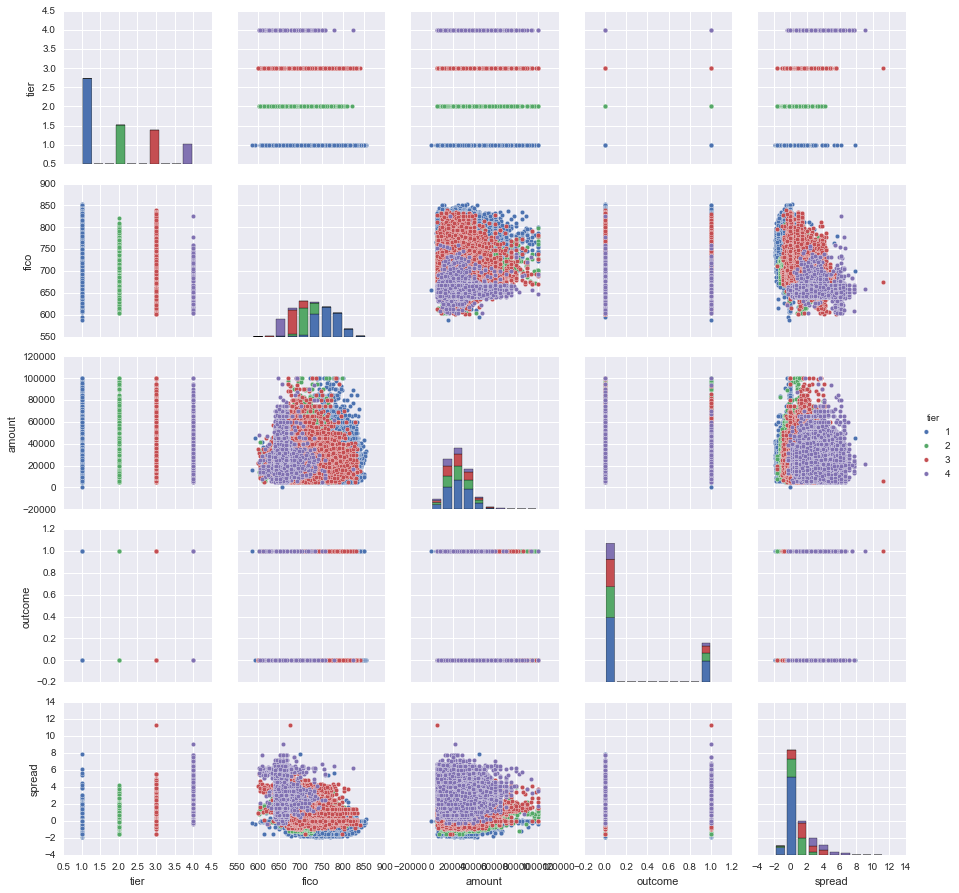

In [11]:
# fico vs amount is interesting
x=data.select('tier','fico','amount','outcome', 'spread').toPandas()
sns.pairplot(x, hue='tier')

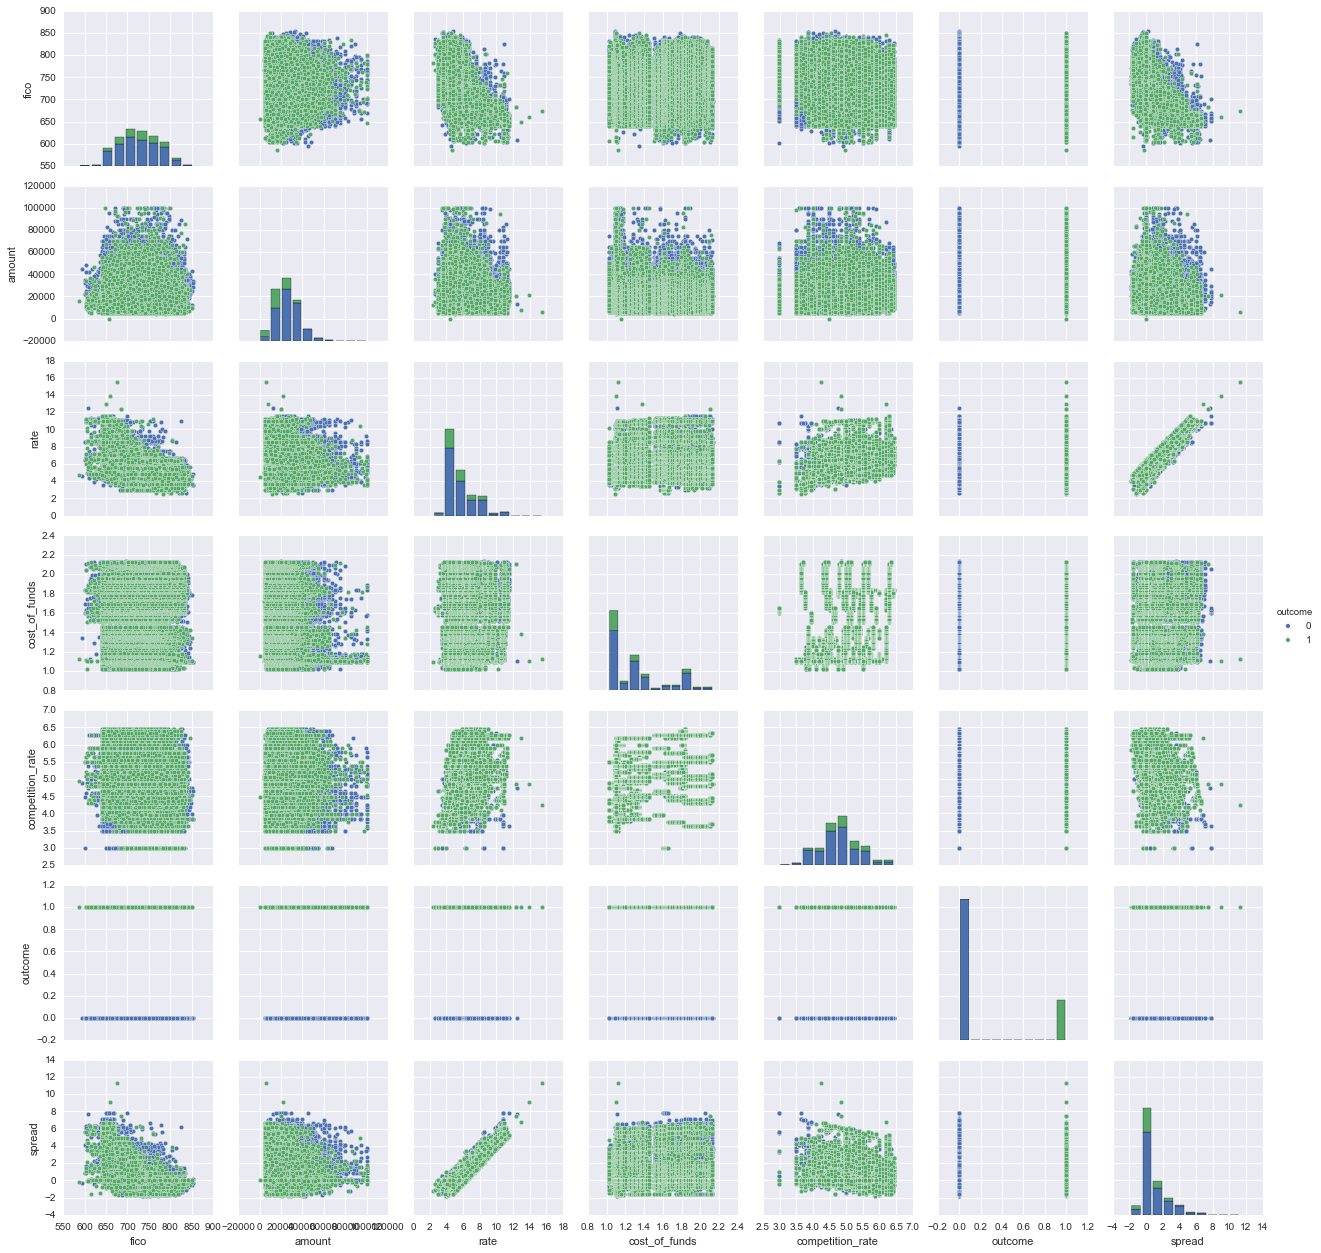

In [12]:
# amount vs amount shows that the loans they are approving are low $ amount loans
# rate vs rate shows the loans they are approving are low interest rate loans
#x=data.select('tier','fico','amount','rate', 'cost_of_funds').toPandas()
x=data.select('fico','amount','rate', 'cost_of_funds', 'competition_rate', 'outcome', 'spread').toPandas()
sns.pairplot(x, hue='outcome')

$NPV=\sum_{n=1}^{n} \frac{Cn}{(1+r)^n} - Co$

In [ ]:
IRR

In [237]:
x = data.groupBy('year').sum('npv').toPandas()
x['sum(npv)'] = round(x['sum(npv)'], 2)
x = x.sort_values('year',0)
x

#spread = data.where(data.tier==1).select('spread').toPandas()
#spread = pd.value_counts(values=spread.spread, ascending=False, bins=10)
#spread

,year,sum(npv)
2,2002,1.453343e+08
0,2003,5.032385e+08
1,2004,4.275195e+08


In [ ]:
NPV for tier, FICO, approve date, term, amount

In [ ]:
EDA